# Exploring photon heights with ICESat-2 (ATL03)

Information obtained primarily from the ATL03 Algorithm Theoretical Basis Document (ATBD, Neumann et al., 2019) and the NSIDC product description page: https://nsidc.org/data/atl03.   

* Notebook author: Alek Petty (relying extensively on the ATBD and product description)    
* Description: Notebook describing the ICESat-2 ATL03 product.   
* Input requirements: Any example ATL03 data file.   
* Date: June 2019
* More info: See the ATL03 Algorithm Theoretical Basis Document (ATBD): https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/ICESat2_ATL03_ATBD_r001.pdf and the known issues document: https://nsidc.org/sites/nsidc.org/files/technical-references/ATL03_Known_Issues_May2019.pdf


## To do

* Talk more about cloud (and negative value) filtering!? I think i'm doing this right by just using a surface window after using the high confidence photons. How else can we classiy the clouds?
* Could show the photon rate/reflectance and talk briefly about Ron's surface finding algorithm. Perhaps finish the tutorial by asking users to generate a coloured scatter plot showing the photon rate as a colour. Need to add the photon rate/background rate to the reader.

## Notebook objectives
* General understanding of the data included in a typical ATL03 file.
* Reading in, plotting and basic analysis of ATL03 data.
* What we can learn from ATL03 to derive the ATL07 surface height segments!


## Notebook instructions
1. Follow along with the notebook tutorial. 
2. Play around changing options and re-running the relevant notebook cells. 

Here I use the hdf5 file from: https://nsidc.org/data/atl03
For the demo below I'm using the file: X
If using this using the ICESat-2 Pangeo instance, you can download the file using the cell below


In [1]:
#Magic function to enable interactive plotting in Jupyter notebook
#Allows you to zoom/pan within plots after generating
#Normally, this would be %matplotlib notebook, but since we're using Juptyerlab, we need a different widget
#%matplotlib notebook
%matplotlib inline

In [39]:
#Import necesary modules
#Use shorter names (np, pd, plt) instead of full (numpy, pandas, matplotlib.pylot) for convenience
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import convert_GPS_time as cGPS
#import seaborn as sns
import pandas as pd
import h5py  
import s3fs
# Use seasborn for nicer looking inline plots
#sns.set(context='notebook', style='darkgrid')
#st = axes_style("whitegrid")

In [6]:
# If data file is stored locally (already grabbed from S3) uncomment the following lines and comment out the below S3 example..
#file_path = '../Data/'
#ATL03_filename = 'ATL03_20181115022655_07250104_001_01.h5'
#localPath = file_path + ATL03_filename
#beamStr='gt1r'

(19105034,)
(19105034,)


In [40]:
# If running on Pangeo instance you can greab data directly from Amazon S3 like so
bucket = 'pangeo-data-upload-oregon'
fs = s3fs.S3FileSystem()
dataDir = 'pangeo-data-upload-oregon/icesat2/'
s3List = fs.ls(dataDir)
print(s3List)
ATL03file='ATL03_20181115022655_07250104_001_01.h5'
s3File='pangeo-data-upload-oregon/icesat2/'+ATL03file
localPath='../Data/'+ATL03file
fs.get(s3File, localPath)


['pangeo-data-upload-oregon/icesat2/ATL03_20181115022655_07250104_001_01.h5', 'pangeo-data-upload-oregon/icesat2/ATL07-01_20181115003141_07240101_001_01.h5', 'pangeo-data-upload-oregon/icesat2/readme.txt', 'pangeo-data-upload-oregon/icesat2/atl03', 'pangeo-data-upload-oregon/icesat2/atl06']


In [4]:
# Python reader based on Pandas. Other reader examples available in readers.py

def getATL03data(fileT, numpy=0, beam='gt1l', maxElev=1e6):
    # Add in a proper description of the function here
    
    # Open the file
    ATL03 = h5py.File(fileT, 'r')
    
    lons=ATL03[beam+'/heights/lon_ph'][:]
    lats=ATL03[beam+'/heights/lat_ph'][:]
    
    # Along track distance from equator i think.
    along_track_distance=ATL03[beam+'/heights/dist_ph_along'][:] 
    
    #  Nathan says it's the number of seconds since the GPS epoch on midnight Jan. 6, 1980 
    delta_time=ATL03[beam+'/heights/delta_time'][:] 
    
    # #Add this value to delta time parameters to compute full gps_seconds
    atlas_epoch=ATL03['/ancillary_data/atlas_sdp_gps_epoch'][:] 
    
    # Conversion of delta_time to a calendar date
    temp = cGPS.convert_GPS_time(atlas_epoch[0] + delta_time, OFFSET=0.0)
    
    # Express delta_time relative to start time of granule
    delta_time_granule=delta_time-delta_time[0]

    year = temp['year'][:].astype('int')
    month = temp['month'][:].astype('int')
    day = temp['day'][:].astype('int')
    hour = temp['hour'][:].astype('int')
    minute = temp['minute'][:].astype('int')
    second = temp['second'][:].astype('int')

    # Primary variables of interest
    
    # Photon height
    heights=ATL03[beam+'/heights/h_ph'][:]
    print(heights.shape)
    
    # Flag for signal confidence
    # column index:  0=Land; 1=Ocean; 2=SeaIce; 3=LandIce; 4=InlandWater
    # values:
        #-- -1: Events not associated with a specific surface type
        #--  0: noise
        #--  1: buffer but algorithm classifies as background
        #--  2: low
        #--  3: medium
        #--  4: high
    signal_confidence=ATL03[beam+'/heights/signal_conf_ph'][:,2] 
    print(signal_confidence.shape)
    
    # Add photon rate and background rate to the reader here
    
    ATL03.close()
    
    if (numpy==1):
        # list the variables you want to output here..
        return along_track_dist, elev
    
    else:
        dF = pd.DataFrame({'heights':heights, 'lons':lons, 'lats':lats, 'signal_confidence':signal_confidence, 
                       'delta_time':delta_time_granule,'along_track_distance':along_track_distance, 'year':year, 'month':month, 'day':day, 'hour':hour, 'second':second})
        
        # Filter out high elevation values 
        #dF = dF[(dF['signal_confidence']>2)]
        # Reset row indexing
        #dF=dF.reset_index(drop=True)
        return dF


In [ ]:
# Read in the data and take a look at the top few rows (change the number in head to increase this..
dF03=getATL03data(localPath, beam=beamStr)
dF03.head(5)

In [1]:
# Plot these photon heights of this section
# Could use seaborn for this (for one line plots) but using matplotlib for increased user flexibility.

plt.figure(figsize=(12, 5))
plt.plot(dF03['delta_time'],dF03['heights'], color='k', marker='.', linestyle='None', alpha=0.3)
plt.xlabel('Delta time (s)')
plt.ylabel('Photon heights (m)')
plt.show()


NameError: name 'plt' is not defined

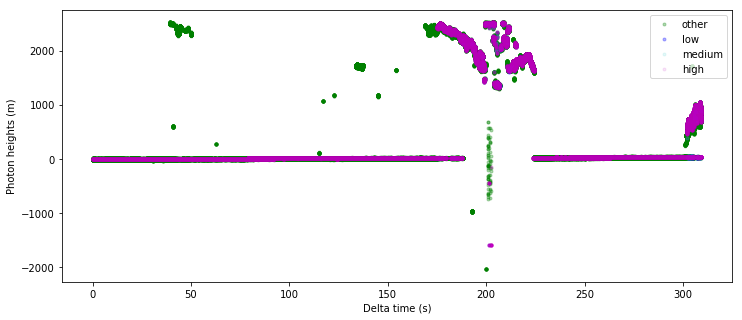

In [9]:
# Plot the photon heights but use the signal confidence to label the markers.

#dF = dF03[(dF['signal_confidence']>2)]
#np.size(np.where(dF03['signal_confidence']==3))
plt.figure(figsize=(12, 5))
plt.plot(dF03[(dF03['signal_confidence']<2)]['delta_time'],dF03[(dF03['signal_confidence']<2)]['heights'], label='other', color='g', marker='.', linestyle='None', alpha=0.3)
plt.plot(dF03[(dF03['signal_confidence']==2)]['delta_time'],dF03[(dF03['signal_confidence']==2)]['heights'], label='low', color='b', marker='.', linestyle='None', alpha=0.3)
plt.plot(dF03[(dF03['signal_confidence']==3)]['delta_time'],dF03[(dF03['signal_confidence']==3)]['heights'], label='medium', color='c', marker='.', linestyle='None', alpha=0.1)
plt.plot(dF03[(dF03['signal_confidence']==4)]['delta_time'],dF03[(dF03['signal_confidence']==4)]['heights'], label='high', color='m', marker='.', linestyle='None', alpha=0.1)
plt.legend(loc=1)
plt.xlabel('Delta time (s)')
plt.ylabel('Photon heights (m)')
plt.show()

# Another (more elegant but less flexible) of doing a plot like this is using seaborn...
#plt.figure(figsize=(12, 5))
#sns.pairplot(x_vars=["delta_time"], y_vars=["heights"], data=dF03, 
#hue="signal_confidence", size=5)
#plt.gca().set_ylim((0, 50000))

In [34]:
# How to do cloud (and negative value) filtering!? Think this is in the generation of ATL07?

In [25]:
# now let's only keep the high confidence photons
dF03ice = dF03[(dF03['signal_confidence']>3)]

# ...and let's apply a hight window around the surface (WHAT IS THIS HEIGHT DEFINED RELATIVE TO IN ATL03)
dF03ice = dF03ice[(abs(dF03ice['heights'])<100)]

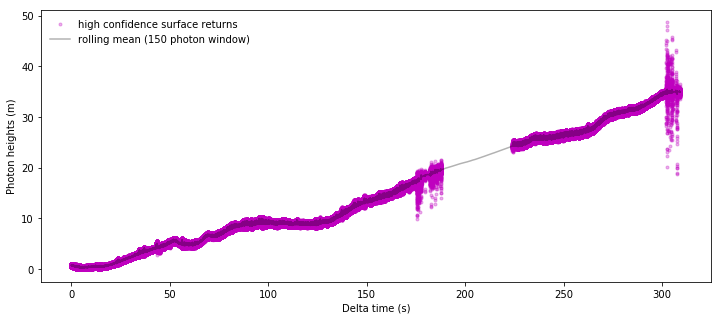

In [35]:
# Plot the data like before

plt.figure(figsize=(12, 5))
plt.plot(dF03ice['delta_time'],dF03ice['heights'], label='high confidence surface returns', color='m', marker='.', linestyle='None', alpha=0.3)
plt.plot(dF03ice['delta_time'].rolling(150).mean(),dF03ice['heights'].rolling(150).mean(), label='rolling mean (150 photon window)', color='k', linestyle='-', alpha=0.3)
plt.legend(loc=2, frameon=False)
plt.xlabel('Delta time (s)')
plt.ylabel('Photon heights (m)')
plt.show()

In [2]:
# We now need to make various corrections...
# ...to convert these heights to a reference sea surface. Ocean tides, dynamic atmosphere, geoid etc.


In [1]:
# Why is this along-track plot so funky???

#plt.figure(figsize=(12, 5))
#plt.plot(dF03ice['along_track_distance'],dF03ice['heights'], label='high confidence surface returns', color='m', marker='.', linestyle='None', alpha=0.3)
#plt.plot(dF03ice['along_track_distance'].rolling(150).mean(),dF03ice['heights'].rolling(150).mean(), label='rolling mean (150 photon window)', color='k', linestyle='-', alpha=0.3)
#plt.legend(loc=2, frameon=False)
#plt.xlabel('along_track_distance (m)')
#plt.ylabel('Photon heights (m)')
#plt.show()



In [ ]:

# Could also show some photon reflectance and color-code the markers using this? Like one of Ron's figures! Where might we have leads?
